<a href="https://colab.research.google.com/github/FrederickAlmeida/FashionMNIST-models-comparison/blob/main/ListaPraticaMLPConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LISTA PRÁTICA DAS UNIDADES 1 E 2**

Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.


Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).



1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .



Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

# Imports e Downloads

In [2]:
# modelagem e dados
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils import data
import joblib

# avaliação
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])

In [5]:
train_ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=augmentation_transforms
)

test_ds = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=augmentation_transforms
)

In [6]:
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

In [7]:
len_train, len_val, len(test_ds)

(51000, 9000, 10000)

In [8]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl = data.DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

In [9]:
instances, targets = next(iter(train_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

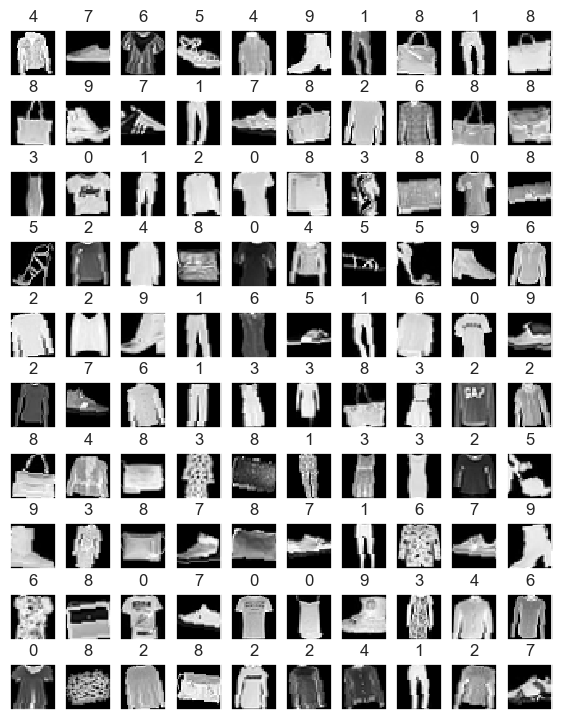

In [10]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

# Funções de treinamento

In [3]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

In [5]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

In [6]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS):
  history = {
    "train_loss": [],
    "val_loss": []
  }

  update_graph = EPOCHS//5
  for epoch in range(1, EPOCHS+1):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {round(train_loss, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7}\n")

  # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
  update_graph = EPOCHS//30
  if update_graph < 1:
    update_graph = 1

  # plotar o gráfico de loss
  fig = plt.figure()
  plt.title("Cross entropy loss")
  plt.plot(history["train_loss"][::update_graph], c="g", label="train")
  plt.plot(history["val_loss"][::update_graph], c="r", label="valid")
  plt.legend()

In [7]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    labels = list(str(i) for i in range(10))
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Modelo base

In [14]:
# processar os dados para que se tornem tensores de 1 dimensão, a fim de utilizar random forest
def preprocess(dataset):
    LENGTH = len(dataset)
    loader = torch.utils.data.DataLoader(dataset, batch_size=LENGTH, shuffle=False)

    for data, labels in loader:
        data = data.numpy().reshape(LENGTH, -1)
        labels = labels.numpy()
        break

    data_transformed = data / 255.0

    return data_transformed, labels

In [15]:
X_train, y_train = preprocess(train_ds)
X_val, y_val = preprocess(val_ds)
X_test, y_test = preprocess(test_ds)

In [17]:
X_train.shape, y_train.shape

((51000, 784), (51000,))

In [19]:
type(X_train)

numpy.ndarray

In [28]:
def train_forest(X_train, y_train, X_val, y_val):
    best_model = 0

    for estimators in range(100, 1001, 100):
        classifier = RandomForestClassifier(n_estimators=estimators, random_state=1)

        classifier.fit(X_train, y_train)

        predictions = classifier.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        print(f"estimators = {estimators}, accuracy = {accuracy:.4f}")

        if (accuracy > best_model):
            joblib.dump(classifier, 'random_forest_model.joblib')
            best_model = accuracy

In [29]:
train_forest(X_train, y_train, X_val, y_val)

estimators = 100, accuracy = 0.8101
estimators = 200, accuracy = 0.8127
estimators = 300, accuracy = 0.8129
estimators = 400, accuracy = 0.8140
estimators = 500, accuracy = 0.8143
estimators = 600, accuracy = 0.8150
estimators = 700, accuracy = 0.8149
estimators = 800, accuracy = 0.8158
estimators = 900, accuracy = 0.8147
estimators = 1000, accuracy = 0.8149


In [ ]:
# carregando o melhor modelo
rf_classifier = joblib.load('random_forest_model.joblib')

In [31]:
predictions = rf_classifier.predict(X_test)

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7650    0.7910    0.7778      1000
           1     0.9863    0.9380    0.9616      1000
           2     0.6409    0.7140    0.6755      1000
           3     0.7914    0.8650    0.8266      1000
           4     0.6765    0.7090    0.6924      1000
           5     0.9422    0.8960    0.9185      1000
           6     0.5626    0.4180    0.4796      1000
           7     0.8763    0.9000    0.8880      1000
           8     0.9310    0.9450    0.9380      1000
           9     0.9102    0.9320    0.9209      1000

    accuracy                         0.8108     10000
   macro avg     0.8082    0.8108    0.8079     10000
weighted avg     0.8082    0.8108    0.8079     10000



# MLP

# Rede Convolucional

# Rede Convolucional consolidada

Ajustando as imagems para ter dimensão 3x224x224, dimensão na qual as arquiteturas vgg foram treinadas

In [9]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_ds_vgg = datasets.FashionMNIST(
    root='data/vgg',
    train=True,
    download=True,
    transform=transform
)

test_ds_vgg = datasets.FashionMNIST(
    root='data/vgg',
    train=False,
    download=True,
    transform=transform
)

length = len(train_ds_vgg)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds_vgg, val_ds_vgg = data.random_split(train_ds_vgg, [len_train, len_val])

In [11]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl_vgg = data.DataLoader(
    train_ds_vgg, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_dl_vgg = data.DataLoader(
    val_ds_vgg, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_dl_vgg = data.DataLoader(
    test_ds_vgg, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

In [12]:
instances, targets = next(iter(train_dl_vgg))
instances.shape, targets.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

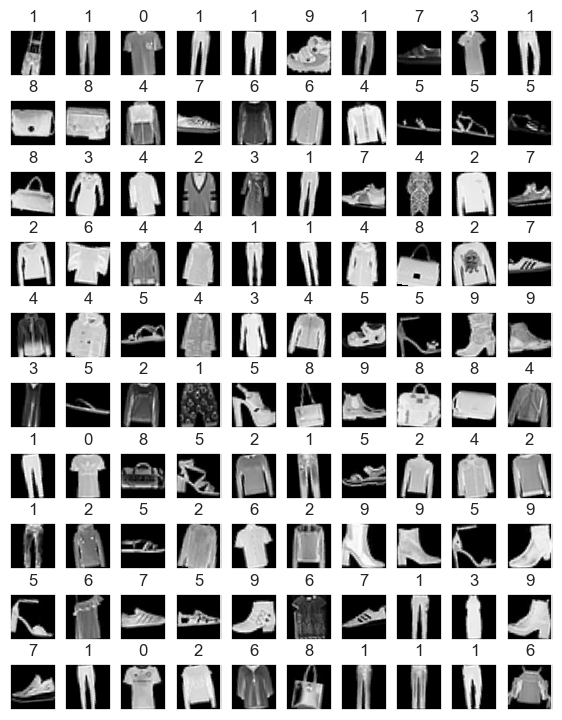

In [13]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(label)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

In [14]:
vgg16_model = models.vgg16(pretrained=True)

c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
vgg16_model.classifier[6] = torch.nn.Linear(vgg16_model.classifier[6].in_features, 10)

print(vgg16_model.classifier[6])

Linear(in_features=4096, out_features=10, bias=True)


In [17]:
for param in vgg16_model.features.parameters():
    param.requires_grad = False

for param in vgg16_model.classifier.parameters():
    param.requires_grad = False

for param in vgg16_model.classifier[6].parameters():
    param.requires_grad = True

In [18]:
for name, param in vgg16_model.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

features.0.weight is frozen
features.0.bias is frozen
features.2.weight is frozen
features.2.bias is frozen
features.5.weight is frozen
features.5.bias is frozen
features.7.weight is frozen
features.7.bias is frozen
features.10.weight is frozen
features.10.bias is frozen
features.12.weight is frozen
features.12.bias is frozen
features.14.weight is frozen
features.14.bias is frozen
features.17.weight is frozen
features.17.bias is frozen
features.19.weight is frozen
features.19.bias is frozen
features.21.weight is frozen
features.21.bias is frozen
features.24.weight is frozen
features.24.bias is frozen
features.26.weight is frozen
features.26.bias is frozen
features.28.weight is frozen
features.28.bias is frozen
classifier.0.weight is frozen
classifier.0.bias is frozen
classifier.3.weight is frozen
classifier.3.bias is frozen
classifier.6.weight is not frozen
classifier.6.bias is not frozen


Epoch 1/10
Train loss: 0.684768
Valid. loss: 0.490353

Epoch 2/10
Train loss: 0.574647
Valid. loss: 0.4652 

Epoch 3/10
Train loss: 0.559325
Valid. loss: 0.448857

Epoch 4/10
Train loss: 0.551107
Valid. loss: 0.443323

Epoch 5/10
Train loss: 0.54757
Valid. loss: 0.438118

Epoch 6/10
Train loss: 0.543342
Valid. loss: 0.435711

Epoch 7/10
Train loss: 0.545725
Valid. loss: 0.433446

Epoch 8/10
Train loss: 0.545231
Valid. loss: 0.455484

Epoch 9/10
Train loss: 0.540827
Valid. loss: 0.426885

Epoch 10/10
Train loss: 0.53716
Valid. loss: 0.422553



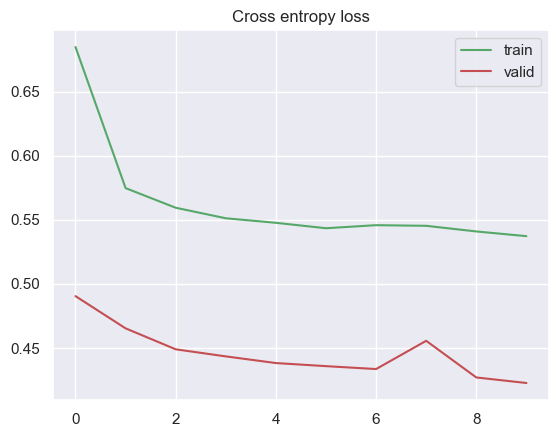

In [19]:
vgg16_model.to(device)
LEARNING_RATE = 0.001
EPOCHS = 10
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

train(vgg16_model, train_dl_vgg, val_dl_vgg, loss_fn, optimizer, device, EPOCHS)

In [20]:
torch.save(vgg16_model.state_dict(), 'vgg16.pth')

In [21]:
test(vgg16_model, test_dl_vgg, device)

              precision    recall  f1-score   support

           0     0.8231    0.7540    0.7871      1000
           1     0.9938    0.9600    0.9766      1000
           2     0.8025    0.7600    0.7807      1000
           3     0.7203    0.8910    0.7966      1000
           4     0.7136    0.7300    0.7217      1000
           5     0.9439    0.9260    0.9349      1000
           6     0.6101    0.5430    0.5746      1000
           7     0.9155    0.9100    0.9127      1000
           8     0.9573    0.9630    0.9601      1000
           9     0.9212    0.9580    0.9392      1000

    accuracy                         0.8395     10000
   macro avg     0.8401    0.8395    0.8384     10000
weighted avg     0.8401    0.8395    0.8384     10000



0.8395

# Comparação